In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import cv2
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

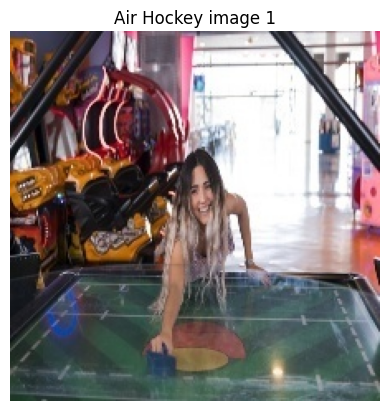

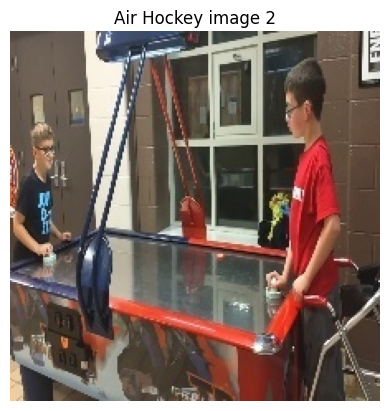

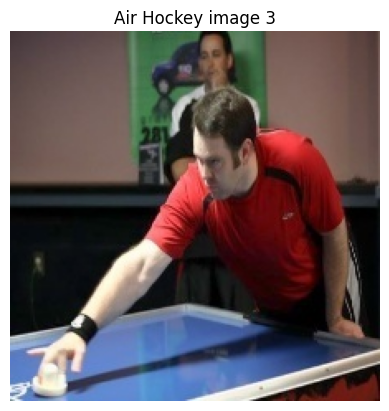

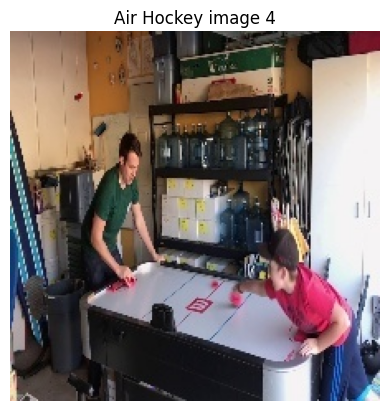

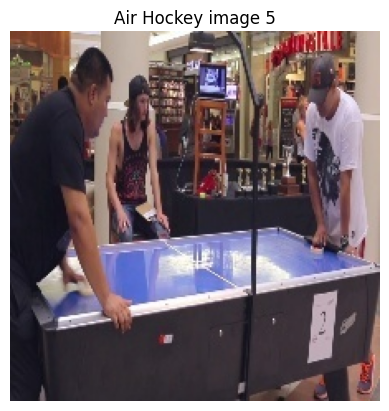

In [2]:
path_to_train = Path("/kaggle/input/sports-classification/train/air hockey")
first_five_images = [p for i, p in enumerate(path_to_train.iterdir()) if i < 5]
for i, img_path in enumerate(first_five_images, start=1):
    im = Image.open(img_path)
    plt.imshow(im)
    plt.axis("off")
    plt.title(f"Air Hockey image {i}")
    plt.show()

In [3]:
train_folder = Path("/kaggle/input/sports-classification/train")
counts = []
for i, sport in enumerate(train_folder.iterdir()):
    if not sport.is_dir():
        continue
    count = sum(1 for j in sport.iterdir() if j.suffix == ".jpg")
    counts.append((sport.name, count))
    print(sport.name, count)

bobsled 138
hurdles 136
snow boarding 117
fly fishing 134
luge 127
sidecar racing 133
ampute football 112
volleyball 142
billiards 145
giant slalom 150
tennis 131
horse racing 139
pole dancing 112
figure skating women 157
rollerblade racing 159
fencing 135
olympic wrestling 167
golf 157
ultimate 97
harness racing 147
football 191
frisbee 131
bungee jumping 125
shot put 149
ice climbing 130
figure skating men 128
rowing 143
bike polo 110
swimming 157
judo 150
axe throwing 113
archery 132
baseball 174
wheelchair basketball 106
log rolling 128
lacrosse 151
rock climbing 141
horse jumping 134
hydroplane racing 108
formula 1 racing 190
curling 141
jousting 118
javelin 136
water cycling 103
speed skating 136
barell racing 123
bull riding 149
horseshoe pitching 102
croquet 134
chuckwagon racing 120
hammer throw 122
rugby 166
pole climbing 118
nascar racing 189
snowmobile racing 147
boxing 116
mushing 111
track bicycle 135
canoe slamon 164
disc golf 123
bmx 140
air hockey 112
rings 157
trapeze

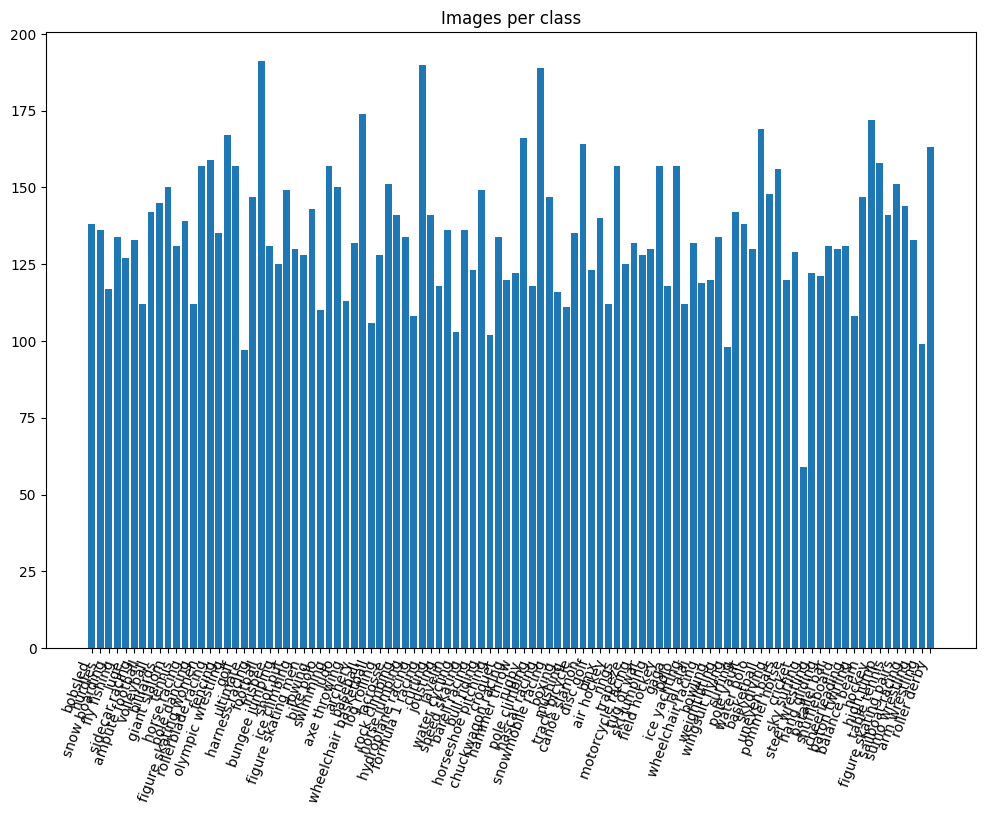

In [4]:
classes = [c for c, _ in counts]
values = [v for _, v in counts]
plt.figure(figsize=(12, 8))
plt.bar(classes, values)
plt.xticks(rotation=70, ha="right")
plt.title("Images per class")
plt.show()

In [5]:
freq = np.array([v for _, v in counts])
print(freq.mean(), freq.std(), freq.var())

134.92 21.378344182840728 457.0335999999999


In [6]:
data = []
for i, a in enumerate(train_folder.iterdir()):
    for k, j in enumerate(a.iterdir()):
        if j.is_file():
            data.append((str(j), a.name))
        if i == 0 and k == 0:
            print(data)

[('/kaggle/input/sports-classification/train/bobsled/029.jpg', 'bobsled')]


In [7]:
val_folder = Path("/kaggle/input/sports-classification/valid")
data_val = []
for i, a in enumerate(val_folder.iterdir()):
    for k, j in enumerate(a.iterdir()):
        if j.is_file():
            data_val.append((str(j), a.name))
        if i == 0 and k == 0:
            print(data_val)

[('/kaggle/input/sports-classification/valid/bobsled/5.jpg', 'bobsled')]


In [8]:
test_folder = Path('/kaggle/input/sports-classification/test')

test_dir = []

for j, sport in enumerate(test_folder.iterdir()):
    for k, i in enumerate(sport.iterdir()):
        if i.is_file():
            test_dir.append((str(i), sport.name))

In [12]:
df_train = pd.DataFrame(data, columns = ["path_to_image", "label"])

df_val = pd.DataFrame(data_val, columns = ["path_to_image", "label"])

test_df = pd.DataFrame(test_dir, columns = ["path_to_image", "label"])

In [13]:
valid_ext = {"jpg", "jpeg"}

train_mask = (
    df_train["path_to_image"]
    .astype(str)
    .str.rsplit(".", n=1)
    .str[-1]
    .str.lower()
    .isin(valid_ext)
)

val_mask = (
    df_val["path_to_image"]
    .astype(str)
    .str.rsplit(".", n=1)
    .str[-1]
    .str.lower()
    .isin(valid_ext)
)

test_mask = (
    test_df["path_to_image"]
    .astype(str)
    .str.rsplit(".", n=1)
    .str[-1]
    .str.lower()
    .isin(valid_ext)
)

test_df = test_df[test_mask].reset_index(drop=True)
df_train = df_train[train_mask].reset_index(drop=True)
df_val   = df_val[val_mask].reset_index(drop=True)

In [14]:
if set(df_val['label']).issubset(set(df_train['label'])):
    classes = sorted(df_train['label'].unique())
    le = LabelEncoder().fit(classes)
else:
    raise ValueError("Val set is not a subset of train set")

df_train['label'] = le.transform(df_train['label'])
df_val['label'] = le.transform(df_val['label'])
test_df['label'] = le.transform(test_df['label'])

In [15]:
from torchvision import transforms

custom_transform = transforms.Compose([
    transforms.ToTensor()
])

class custom_dataset(Dataset):

    def __init__(self, features, labels, transform):
        self.features = features
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if self.features.iloc[idx].rsplit(".", 1)[-1].lower() not in {"jpg", "jpeg"}:
            raise ValueError("Non-jpg or jpeg image file")
        img = Image.open(self.features.iloc[idx]).convert("RGB")
        img = self.transform(img)
        return img, torch.tensor(self.labels.iloc[idx], dtype = torch.long)

In [16]:
train_dataset = custom_dataset(df_train['path_to_image'], df_train['label'], custom_transform)
val_dataset = custom_dataset(df_val['path_to_image'], df_val['label'], custom_transform)
test_dataset = custom_dataset(test_df['path_to_image'], test_df['label'], custom_transform)

In [17]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [18]:
class ResNetBlock(nn.Module):

    def __init__(self, input_channels, out_channels, identity_downsample=None, stride=1):
        super().__init__()
        self.input_channels = input_channels
        self.out_channels = out_channels
        self.identity_downsample = identity_downsample
        self.conv1 = nn.Conv2d(input_channels, out_channels, kernel_size = 1, stride = 1, padding = 0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = stride, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels*4, kernel_size = 1, stride = 1, padding = 0)
        self.bn3 = nn.BatchNorm2d(out_channels*4)
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)

        return x


class resnet(nn.Module):

    def __init__(self, num_of_channels, n_classes, layers, block):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(num_of_channels, self.in_channels, kernel_size = 7, stride = 2, padding = 3)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, n_classes)
        self.layer1 = self._make_layer(block, layers[0], 64, 1)
        self.layer2 = self._make_layer(block, layers[1], 128, 2)
        self.layer3 = self._make_layer(block, layers[2], 256, 2)
        self.layer4 = self._make_layer(block, layers[3], 512, 2)

    def _make_layer(self, block, num_of_residualBlocks, out_channels, stride):
        layers = []
        identity_downsample = None

        if stride != 1 or self.in_channels != out_channels*4:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*4, kernel_size=1, stride=stride),
                                               nn.BatchNorm2d(out_channels*4))

        layers.append(block(self.in_channels, out_channels, identity_downsample, stride=stride))
        self.in_channels = out_channels*4

        for i in range(num_of_residualBlocks-1):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1) # flatten after first dimension i.e. batch_size
        x = self.fc(x)
        return x

In [19]:
resnet101 = resnet(3, 100, [3, 4, 23, 3],ResNetBlock)
optimizer = optim.Adam(resnet101.parameters(), lr = 0.00001, weight_decay = 1e-4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet101.to(device)

resnet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=2048, out_features=100, bias=True)
  (layer1): Sequential(
    (0): ResNetBlock(
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64

In [20]:
criterion = nn.CrossEntropyLoss()

In [21]:
from sklearn.metrics import f1_score

In [22]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# -----------------------------
# Metric storage
# -----------------------------
train_acc_hist, val_acc_hist = [], []
train_loss_hist, val_loss_hist = [], []
train_f1_hist, val_f1_hist = [], []

num_epochs = 50

# -----------------------------
# Training loop
# -----------------------------
for i in range(num_epochs):

    # -------- TRAIN --------
    resnet101.train()

    all_pred = []
    all_true = []
    train_loss = 0.0
    correct = 0
    total_samples_train = 0
    num_batches = 0

    for batch_features, batch_labels in train_loader:

        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()
        out = resnet101(batch_features)
        loss = criterion(out, batch_labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(out, 1)

        correct += (predicted == batch_labels).sum().item()
        total_samples_train += batch_labels.size(0)
        num_batches += 1

        all_pred.append(predicted.cpu())
        all_true.append(batch_labels.cpu())

    y_pred = torch.cat(all_pred).numpy()
    y_true = torch.cat(all_true).numpy()

    train_acc = 100 * correct / total_samples_train
    train_loss /= num_batches
    train_f1 = f1_score(y_true, y_pred, average="macro")

    train_acc_hist.append(train_acc)
    train_loss_hist.append(train_loss)
    train_f1_hist.append(train_f1)

    print("-" * 10)
    print(f"Epoch {i+1}")
    print(f"Train acc: {train_acc:.2f}")
    print(f"Train loss: {train_loss:.4f}")
    print(f"Train F1: {train_f1:.4f}")

    # -------- VALIDATION --------
    resnet101.eval()

    all_pred = []
    all_true = []
    val_loss = 0.0
    correct = 0
    total_samples_val = 0
    num_batches = 0

    with torch.no_grad():
        for batch_features, batch_labels in val_loader:

            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            out = resnet101(batch_features)
            loss = criterion(out, batch_labels)

            val_loss += loss.item()
            _, predicted = torch.max(out, 1)

            correct += (predicted == batch_labels).sum().item()
            total_samples_val += batch_labels.size(0)
            num_batches += 1

            all_pred.append(predicted.cpu())
            all_true.append(batch_labels.cpu())

    y_pred = torch.cat(all_pred).numpy()
    y_true = torch.cat(all_true).numpy()

    val_acc = 100 * correct / total_samples_val
    val_loss /= num_batches
    val_f1 = f1_score(y_true, y_pred, average="macro")

    val_acc_hist.append(val_acc)
    val_loss_hist.append(val_loss)
    val_f1_hist.append(val_f1)

    print(f"Val acc: {val_acc:.2f}")
    print(f"Val loss: {val_loss:.4f}")
    print(f"Val F1: {val_f1:.4f}")

# -----------------------------
# Plot & save graphs
# -----------------------------
epochs = range(1, num_epochs + 1)

# Accuracy
plt.figure()
plt.plot(epochs, train_acc_hist, label="Train Accuracy")
plt.plot(epochs, val_acc_hist, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("accuracy.png")
plt.close()

# Loss
plt.figure()
plt.plot(epochs, train_loss_hist, label="Train Loss")
plt.plot(epochs, val_loss_hist, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("loss.png")
plt.close()

# F1 Score
plt.figure()
plt.plot(epochs, train_f1_hist, label="Train F1")
plt.plot(epochs, val_f1_hist, label="Val F1")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.savefig("f1_score.png")
plt.close()

----------
Epoch 1
Train acc: 2.85
Train loss: 4.4922
Train F1: 0.0152
Val acc: 3.40
Val loss: 4.3307
Val F1: 0.0105
----------
Epoch 2
Train acc: 6.92
Train loss: 4.0841
Train F1: 0.0484
Val acc: 9.20
Val loss: 3.9327
Val F1: 0.0473
----------
Epoch 3
Train acc: 11.64
Train loss: 3.7315
Train F1: 0.0927
Val acc: 16.80
Val loss: 3.3695
Val F1: 0.1238
----------
Epoch 4
Train acc: 16.93
Train loss: 3.4355
Train F1: 0.1441
Val acc: 19.40
Val loss: 3.1260
Val F1: 0.1537
----------
Epoch 5
Train acc: 20.92
Train loss: 3.1968
Train F1: 0.1836
Val acc: 28.40
Val loss: 2.8002
Val F1: 0.2433
----------
Epoch 6
Train acc: 25.24
Train loss: 3.0147
Train F1: 0.2270
Val acc: 29.80
Val loss: 2.6943
Val F1: 0.2658
----------
Epoch 7
Train acc: 29.03
Train loss: 2.8268
Train F1: 0.2682
Val acc: 33.40
Val loss: 2.5042
Val F1: 0.2940
----------
Epoch 8
Train acc: 32.52
Train loss: 2.6591
Train F1: 0.3014
Val acc: 39.40
Val loss: 2.3508
Val F1: 0.3579
----------
Epoch 9
Train acc: 35.95
Train loss: 2.52

In [27]:
from sklearn.metrics import f1_score

test_acc = 0.0
correct = 0
total_samples = 0
all_pred = []
all_true = []
y_pred = []
y_true = []

resnet101.eval()
with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        
        out = resnet101(batch_features)
        _, predicted = torch.max(out, 1)
        correct += (predicted == batch_labels).sum().item()
        total_samples += batch_labels.shape[0]
        all_pred.append(predicted.cpu())
        all_true.append(batch_labels.cpu())

y_pred = torch.cat(all_pred).numpy()
y_true = torch.cat(all_true).numpy()

test_acc = (correct / total_samples)*100

test_f1 = f1_score(y_true, y_pred, average="macro")

print(f"Test acc: {test_acc:.2f}")
print(f"Test F1: {test_f1:.4f}")

Test acc: 70.40
Test F1: 0.6883
